
### Grid Enivornment Definition 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

In [3]:
class GridWorld:
    def __init__(self, grid_size, posA, posA_prime, posB, posB_prime, actions, action_representations=None):
        self.grid_size = grid_size
        self.A = posA
        self.A_prime = posA_prime
        self.B = posB
        self.B_prime = posB_prime
        self.action_space = actions
        self.action_representations = action_representations

    def step(self, state, action, rw_scale=1.):
        '''
        Define the Grid World's MDP dynamics
        '''
        # special states
        if state == self.A:
            return self.A_prime, rw_scale*10
        if state == self.B:
            return self.B_prime, rw_scale*5

        # others
        next_state = (np.array(state) + action).tolist()
        x, y = next_state
        # boundaries
        if x < 0 or x >= self.grid_size or y < 0 or y >= self.grid_size:
            reward = -1.0
            next_state = state
        # all other
        else:
            reward = 0
        return next_state, rw_scale*reward

    def value_function(self, action_probability, discount):
        A = -1 * np.eye(self.grid_size * self.grid_size)
        b = np.zeros(self.grid_size * self.grid_size)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                s = [i, j]  # current state
                index_s = np.ravel_multi_index(s, (self.grid_size, self.grid_size))
                for a in self.action_space:
                    s_, r = self.step(s, a)
                    index_s_ = np.ravel_multi_index(s_, (self.grid_size, self.grid_size))
                    A[index_s, index_s_] += action_probability * discount
                    b[index_s] -= action_probability * r
        x = np.linalg.solve(A, b)
        return x

    def value_iteration(self, action_probability, discount, rw_scale=1.):
        """
        Calculate the state-value function, using the Bellman equation
        """
        value = np.zeros((self.grid_size, self.grid_size))
        while True:
            # keep iteration until convergence
            new_value = np.zeros_like(value)
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    for action in self.action_space:
                        (next_i, next_j), reward = self.step([i, j], action, rw_scale)
                        # Bellman expectation equation
                        new_value[i, j] += action_probability * (reward + discount * value[next_i, next_j])
            if np.sum(np.abs(value - new_value)) < 1e-4: # cut-off
                return new_value
            else:
                value = new_value

    def optimal_value_function(self, discount):
        value = np.zeros((self.grid_size, self.grid_size))
        while True:
            # keep iteration until convergence
            new_value = np.zeros_like(value)
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    values = []
                    for action in self.action_space:
                        (next_i, next_j), reward = self.step([i, j], action)
                        # value iteration
                        values.append(reward + discount * value[next_i, next_j])
                    new_value[i, j] = np.max(values) # !
            if np.sum(np.abs(new_value - value)) < 1e-4:
                return new_value
            value = new_value


    def draw(self, image):
        """
        Illustration for the tabular world example
        :param image:
        :return:
        """
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = image.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(image):
            # add state labels
            if [i, j] == self.A:
                val = str(val) + " (A)"
            if [i, j] == self.A_prime:
                val = str(val) + " (A')"
            if [i, j] == self.B:
                val = str(val) + " (B)"
            if [i, j] == self.B_prime:
                val = str(val) + " (B')"
            tb.add_cell(i, j, width, height, text=val,
                        loc='center', facecolor='white')

        # Row and column labels...
        for i in range(len(image)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')
        ax.add_table(tb)

    def draw_policy(self, optimal_values):
        """
        Represent the optimal policy on the grid
        :param values:
        :return:
        """
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = optimal_values.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(optimal_values):
            next_vals=[]
            for action in self.action_space:
                next_state, _ = self.step([i, j], action)
                next_vals.append(optimal_values[next_state[0],next_state[1]])

            best_actions=np.where(next_vals == np.max(next_vals))[0]
            val=''
            for ba in best_actions:
                val+=self.action_representations[ba]
            # add state labels
            if [i, j] == self.A:
                val = str(val) + " (A)"
            if [i, j] == self.A_prime:
                val = str(val) + " (A')"
            if [i, j] == self.B:
                val = str(val) + " (B)"
            if [i, j] == self.B_prime:
                val = str(val) + " (B')"

            tb.add_cell(i, j, width, height, text=val,
                        loc='center', facecolor='white')
        # Row and column labels...
        for i in range(len(optimal_values)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')

        ax.add_table(tb)

#### Definition of th grid world parameters
5*5 grid with four possible actions Left,Up,Down and Right.All states has 0 reward except 2 special states A and B has that actions to corresponding A' and B' result, in order,+10 and +5 rewards.Discount factor is 0.9 and actions are equiprobable.

In [4]:
grid_size = 5
A_pos = [0, 1]
A_prime_pos = [4, 1]
B_pos = [0, 3]
B_prime_pos = [2, 3]
discount = 0.9

# left, up, right, down
ACTIONS = [np.array([0, -1]),
           np.array([-1, 0]),
           np.array([0, 1]),
           np.array([1, 0])]
ACTIONS_REP = [ '←', '↑', '→', '↓']

Instanciation of `GridWorld class` based on above parameter 

In [5]:
gw = GridWorld(grid_size, A_pos, A_prime_pos, B_pos, B_prime_pos, ACTIONS)

Performing value iteration 

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 338 ms


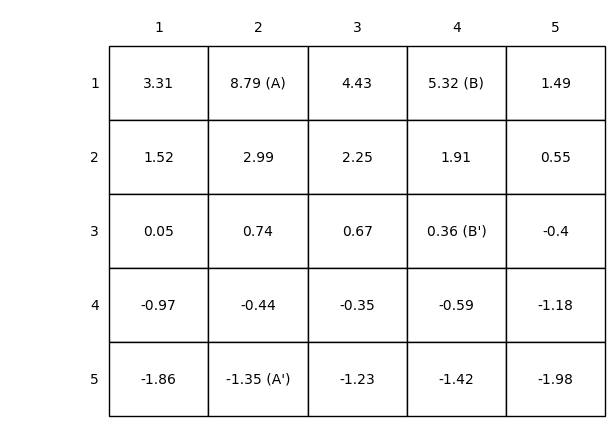

In [6]:
%%time
vf = gw.value_iteration(action_probability=0.25, discount=0.9)
gw.draw(np.round(vf.reshape(gw.grid_size, gw.grid_size), decimals=2))

Calculating optimal policy and value functions to navigate the grid world

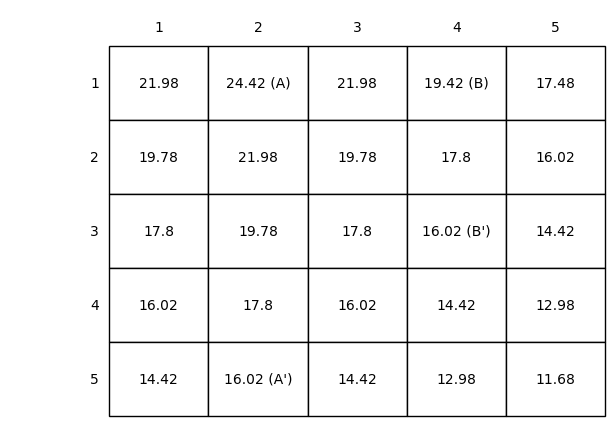

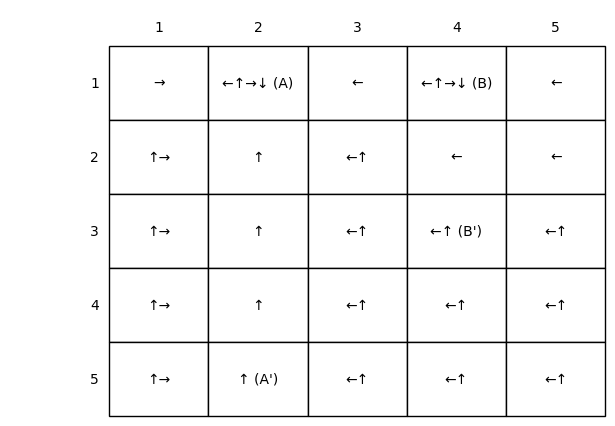

In [10]:
gw = GridWorld(grid_size, A_pos, A_prime_pos, B_pos, B_prime_pos, ACTIONS, ACTIONS_REP)
ovf = gw.optimal_value_function(discount=0.9)
gw.draw(np.round(ovf.reshape(gw.grid_size, gw.grid_size), decimals=2))
op = gw.draw_policy(ovf)